In [72]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import os 
import logging
import time
import logging.config                    
import importlib
import yass
from yass import preprocess
from yass import detect
from yass import threshold
from yass import cluster
from yass import deconvolute
from yass import templates as get_templates
from yass.batch import RecordingsReader
from yass.util import load_logging_config_file
from pylab import savefig
import glob




ngroup=25
var_pca_all=np.zeros(ngroup)
var_wpca_all=np.zeros(ngroup)
nclass_pca_all=np.zeros(ngroup)
nclass_wpca_all=np.zeros(ngroup)

In [74]:
path ="/home/bryancsouza/YASS/"
os.chdir(path)

FILE_EXISTS = 'overwrite'

config_files = glob.glob('./*group*.yaml')
print(len(config_files))
for igroup in range(ngroup):
    config = config_files[igroup]

    print(igroup)
    print(config)
    


    # yass.pipeline.run inputs
    logger_level='INFO'
    clean=False;
    output_dir='tmp_wpca_raw/';
    complete = False;



    # configure logging module to get useful information
    #logging.basicConfig(level=logging.INFO)

    # set yass configuration parameters
    yass.set_config(config)

    # load yass configuration parameters
    CONFIG = yass.read_config()
    ROOT_FOLDER = CONFIG.data.root_folder
    TMP_FOLDER = os.path.join(ROOT_FOLDER, output_dir)


    # remove tmp folder if needed
    if os.path.exists(TMP_FOLDER) and clean:
        shutil.rmtree(TMP_FOLDER)

    # create TMP_FOLDER if needed
    if not os.path.exists(TMP_FOLDER):
        os.makedirs(TMP_FOLDER)


    # load logging config file
    logging_config = load_logging_config_file()
    logging_config['handlers']['file']['filename'] = os.path.join(TMP_FOLDER,'yass.log')

    logging_config['root']['level'] = 'INFO'

    # configure logging
    logging.config.dictConfig(logging_config)

    # instantiate logger
    logger = logging.getLogger(__name__)

    # print yass version
    logger.info('YASS version: %s', yass.__version__)


    # preprocess
    start = time.time()
    (standarized_path,
         standarized_params,
         channel_index,
         whiten_filter) = (preprocess
                           .run(output_directory=output_dir,
                            if_file_exists=FILE_EXISTS))

    time_preprocess = time.time() - start

    gmm_params = {
        'gmtype': 'idist', # chose between 'idist', 'ipeak' and 'iinf' 
        'use_channel_features': True,
        'max_samples': 1000,
        'n_components': 8,
        'replicates': 10} 


    # detect using wavelets and wPCA
    start = time.time()
    (score_wpca, spike_index_clear_wpca,
     spike_index_all_wpca) = detect.wpca.run(standarized_path,
                                   standarized_params,
                                   channel_index,
                                   whiten_filter,
                                   output_directory=output_dir,
                                   if_file_exists=FILE_EXISTS,
                                   save_results=CONFIG.detect.save_results,
                                   gmm_params=gmm_params)
    time_detect = time.time() - start

    """End of modifications"""

    recordings = RecordingsReader(standarized_path)

    # cluster
    start = time.time()
    spike_train_clear_wpca, tmp_loc_wpca, vbParam_wpca = cluster.run(
        score_wpca,
        spike_index_clear_wpca,
        output_directory=output_dir,
        if_file_exists=FILE_EXISTS,
        save_results=CONFIG.cluster.save_results)
    time_cluster = time.time() - start

    # get templates
    start = time.time()
    (templates_wpca,
     spike_train_clear_after_templates_wpca,
     groups_wpca,
     idx_good_templates_wpca) = get_templates.run(
        spike_train_clear_wpca, tmp_loc_wpca,
        output_directory=output_dir,
        if_file_exists=FILE_EXISTS,
        save_results=CONFIG.templates.save_results)
    time_templates = time.time() - start


    # run deconvolution
    start = time.time()
    spike_train_wpca = deconvolute.run(spike_index_all_wpca, templates_wpca,
                                  output_directory=output_dir)
    time_deconvolution = time.time() - start



    # yass.pipeline.run inputs

    logger_level='INFO'
    clean=False;
    output_dir='tmp_pca_raw/';
    complete = False;

    # configure logging module to get useful information
    #logging.basicConfig(level=logging.INFO)

    # set yass configuration parameters
    yass.set_config(config)

    # load yass configuration parameters
    CONFIG = yass.read_config()
    ROOT_FOLDER = CONFIG.data.root_folder
    TMP_FOLDER = os.path.join(ROOT_FOLDER, output_dir)


    # remove tmp folder if needed
    if os.path.exists(TMP_FOLDER) and clean:
        shutil.rmtree(TMP_FOLDER)

    # create TMP_FOLDER if needed
    if not os.path.exists(TMP_FOLDER):
        os.makedirs(TMP_FOLDER)


    # load logging config file
    logging_config = load_logging_config_file()
    logging_config['handlers']['file']['filename'] = os.path.join(TMP_FOLDER,'yass.log')

    logging_config['root']['level'] = 'INFO'

    # configure logging
    logging.config.dictConfig(logging_config)

    # instantiate logger
    logger = logging.getLogger(__name__)

    # print yass version
    logger.info('YASS version: %s', yass.__version__)

    # preprocess
    start = time.time()
    (standarized_path,
         standarized_params,
         channel_index,
         whiten_filter) = (preprocess
                           .run(output_directory=output_dir,
                            if_file_exists=FILE_EXISTS))

    time_preprocess = time.time() - start

    # gmm_params = {
    #     'gmtype': 'idist', # chose between 
    #     'use_channel_features': True,
    #     'max_samples': 1000} # or None


    # detect using PCA
    start = time.time()
    (score_pca, spike_index_clear_pca,
     spike_index_all_pca) = detect.run(standarized_path,
                                   standarized_params,
                                   channel_index,
                                   whiten_filter,
                                   output_directory=output_dir,
                                   if_file_exists=FILE_EXISTS,
                                   save_results=CONFIG.detect.save_results)
    time_detect = time.time() - start


    recordings = RecordingsReader(standarized_path)

    # cluster
    start = time.time()
    spike_train_clear_pca, tmp_loc_pca, vbParam_pca = cluster.run(
        score_pca,
        spike_index_clear_pca,
        output_directory=output_dir,
        if_file_exists=FILE_EXISTS,
        save_results=CONFIG.cluster.save_results)
    time_cluster = time.time() - start

    # get templates
    start = time.time()
    (templates_pca,
     spike_train_clear_after_templates_pca,
     groups_pca,
     idx_good_templates_pca) = get_templates.run(
        spike_train_clear_pca, tmp_loc_pca,
        output_directory=output_dir,
        if_file_exists=FILE_EXISTS,
        save_results=CONFIG.templates.save_results)
    time_templates = time.time() - start


    # run deconvolution
    start = time.time()
    spike_train_pca = deconvolute.run(spike_index_all_pca, templates_pca,
                                  output_directory=output_dir)
    time_deconvolution = time.time() - start





    nclass = np.max(spike_train_wpca[:,1])+1
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, nclass))
    win = np.arange(-30,30+1)
    var_wpca = np.zeros((nclass,1))
    for jclus in range(nclass):
        idx = np.where(np.logical_and(np.logical_and(spike_train_wpca[:,0]<(recordings.data.shape[0]-31),spike_train_wpca[:,0]>30),spike_train_wpca[:,1]==jclus))[0]
        ich2 = tmp_loc_wpca[groups_wpca[jclus][0]]
        wave=[];
        for iwin in win:
            wave.append(np.std(recordings.data[spike_train_wpca[idx,0]+iwin,ich2]))
        aux2 = np.asarray(wave)
        aux3 = np.mean(aux2,axis=0)
    #         print(aux3)
        var_wpca[jclus] = aux3

    nclass = np.max(spike_train_pca[:,1])+1
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, nclass))
    win = np.arange(-30,30+1)
    var_pca = np.zeros((nclass,1))
    for jclus in range(nclass):
        idx = np.where(np.logical_and(np.logical_and(spike_train_pca[:,0]<(recordings.data.shape[0]-31),spike_train_pca[:,0]>30),spike_train_pca[:,1]==jclus))[0]
        ich2 = tmp_loc_pca[groups_pca[jclus][0]]
        wave=[];
        for iwin in win:
            wave.append(np.std(recordings.data[spike_train_pca[idx,0]+iwin,ich2]))
        aux2 = np.asarray(wave)
        aux3 = np.mean(aux2,axis=0)
        if np.isnan(aux3):
            aux3= 0
    #         print(aux3)
        var_pca[jclus] = aux3


    var_pca_all[igroup] = np.mean(var_pca[var_pca!=0])
    var_wpca_all[igroup] = np.mean(var_wpca[var_wpca!=0])
    nclass_pca_all[igroup] = len(var_pca[var_pca!=0])
    nclass_wpca_all[igroup] = len(var_wpca[var_wpca!=0])

25
0
./config_raw_dataset_group9.yaml



100%|██████████| 1/1 [00:06<00:00,  6.85s/it]


yass.preprocess.whiten@matrix 30/01/2019 11:55:34 INFO Computing whitening matrix...



100%|██████████| 1/1 [00:09<00:00,  9.76s/it]

100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


yass.cluster.run@run 30/01/2019 12:00:53 INFO Randomly subsampling...
yass.cluster.run@run 30/01/2019 12:00:53 INFO Triaging...
yass.cluster.run@run 30/01/2019 12:00:57 INFO Coresetting...
yass.cluster.run@run 30/01/2019 12:00:58 INFO Masking...
yass.cluster.run@run 30/01/2019 12:00:58 INFO Clustering...
yass.cluster.util@run_cluster 30/01/2019 12:00:58 INFO Processing channel 0
1.0418187806778545
yass.cluster.util@run_cluster 30/01/2019 12:00:58 INFO Processing channel 1
1.868456775078597
yass.cluster.util@run_cluster 30/01/2019 12:00:58 INFO Processing channel 2
1.695153766397678
yass.cluster.util@run_cluster 30/01/2019 12:00:58 INFO Processing channel 3
1.5865498992181855
yass.cluster.util@run_cluster 30/01/2019 12:00:58 INFO Processing channel 4
0.9137268920831271
yass.cluster.util@run_cluster 30/01/2019 12:00:58 INFO Processing channel 5
1.6685312741759308
yass.cluster.util@run_cluster 30/01/2019 12:00:58 INFO Processing channel 6
0.9094097918991776


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


yass.cluster.util@run_cluster 30/01/2019 12:00:58 INFO Processing channel 7
1.0913384101597439
yass.cluster.util@run_cluster 30/01/2019 12:00:58 INFO Processing channel 8
1.0696591543907952
yass.cluster.util@run_cluster 30/01/2019 12:00:58 INFO Processing channel 9
1.511361056559878
yass.cluster.util@run_cluster 30/01/2019 12:00:58 INFO Processing channel 10
1.678080895001617
yass.cluster.util@run_cluster 30/01/2019 12:00:59 INFO Processing channel 11
1.181038513216052
yass.cluster.util@run_cluster 30/01/2019 12:00:59 INFO Processing channel 12
1.3868056982551762
yass.cluster.util@run_cluster 30/01/2019 12:00:59 INFO Processing channel 13
1.8074962199896052
yass.cluster.util@run_cluster 30/01/2019 12:00:59 INFO Processing channel 14
0.9035249932205399
yass.cluster.util@run_cluster 30/01/2019 12:00:59 INFO Processing channel 15
0.9155735738185559
yass.cluster.util@run_cluster 30/01/2019 12:00:59 INFO Processing channel 16
0.8251732518274354
yass.cluster.util@run_cluster 30/01/2019 12:00


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


yass.templates.run@run 30/01/2019 12:01:01 INFO Templates done in 0 seconds.



100%|██████████| 1/1 [00:18<00:00, 18.98s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.07s/it]

100%|██████████| 1/1 [00:09<00:00,  9.81s/it]

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


1.6516413543086568
1.6525483864138921
1.68852963541226
1.7343028043220496
3.5201000528170767


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.6577552914566343
1.9840948306428916
4.209280017845285
2.9509243534895333
1.8240655450255814
1.9101528961298089
2.654754784960946
2.2661959742622817
2.333035332546077
2.327080342409757
2.631448704865483
2.5793720156355935
2.332204531558087
1.9059953018269018
1.9457687664140617
1.8026710411103843
1.8206678296144623
1.5452375552015527
2.114767234130041
1.5775359676905625
1.3875649354882047
1.5607702316713654
1.535023243701525
1.3701050462691338
1.3716460322583754



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:15<00:00, 15.87s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value enc

1
./config_raw_dataset_group18.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.10s/it]

100%|██████████| 1/1 [00:08<00:00,  8.74s/it]

100%|██████████| 1/1 [00:02<00:00,  2.56s/it]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


0.620868558387292
0.6361749026108664
0.6628685172159912
0.9026985421300462
0.7827792053458912
0.765100527412111


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.7889023720607427
0.7755967678110667
0.9653820032036631
1.0501473126057927
1.0885818167059138
1.3669941757460082
1.1768111017470175
1.2898010077735091
1.3274407981283962
1.219690206172698
1.2270248863157136
1.2298667749272625
0.9644348719952491
0.970379012999265
0.9345295139289402
0.9470406020015273
0.8823978199590531
0.8588647479706016
0.8619705617638469
0.8526337808415331
0.8640796056592527
0.8356064286392249
0.8232000880037085
0.7718987842189028



100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

100%|██████████| 1/1 [00:14<00:00, 14.30s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.23s/it]

100%|██████████| 1/1 [00:08<00:00,  8.96s/it]

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


1.5078504369510848
1.359969105622005
1.8346117517108638
2.432531049685952
2.178247784844731
1.7276258098225497


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.7522564585132563
1.514610225264474
1.9476747717199991
2.0347566428085737
1.9006463395567514
2.3043791192832233
1.5726599333879618
2.292771601762323
1.9148764772491431
1.4853770395276726
1.5283876962267182
1.4975020038705058
1.3961045252414706
1.4706583074493027
1.3586325923440503
1.426859428745274
1.3563055811067424
1.297772057192016
1.3309834190003942
1.2787050666334285
1.2127869483797304
1.272937191686171
1.1997269018856926
1.1582613692599553



100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:10<00:00, 10.17s/it]


2
./config_raw_dataset_group7.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.42s/it]

100%|██████████| 1/1 [00:09<00:00,  9.08s/it]

100%|██████████| 1/1 [00:02<00:00,  2.64s/it]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


0.04277065742328197
0.03150849691786587
0.4081748319904077


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.3338639286231123
0.5222956843007593
0.8569782487805819
0.9750295983820254
0.8400353067839712
1.6292452086665346
1.6971932063795747
1.8780914646725513
1.3501752834507306
4.855337337501731
10.41110011580064
6.216750196572716
4.893272516324283
4.334308726061828
4.161231433423597
3.2673341011617563
2.1821970775096577
3.775878547754846
2.8267633284798035
2.184734651369296
1.5510758493885535
0.7831550589952518
0.772956451680653
0.8062930283735079
0.8247093077620585
0.7238086175484539
0.6594143985557878



100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:15<00:00, 15.72s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.32s/it]

100%|██████████| 1/1 [00:09<00:00,  9.05s/it]

100%|██████████| 1/1 [00:00<00

2.7384700472811163


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: divide by zero encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.9149303634389088
3.249990186056696
2.7753514710356817
3.099866024287176
3.342101483757504
2.612421029289841
2.839977601433811
2.26317269324305
2.4282472874694867
3.0983041685534474
2.5882984347275384
2.1621222562434195
2.038650682130255
1.631458141180114
1.916281790195437
1.9828993684174632
2.068833245560346
1.8998052631473168
2.0303507064955117
2.110632035109595
1.969148093532449
1.7813342082598829
1.7608069302879008
1.7504795248957508
1.7507623920094055
1.6822090670009335
1.594710626775098
1.7150626256683148
1.6514331029594622



100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:32<00:00, 32.14s/it]


3
./config_raw_dataset_group23.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.36s/it]

100%|██████████| 1/1 [00:18<00:00, 18.44s/it]

100%|██████████| 1/1 [00:03<00:00,  3.50s/it]

100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


0.5317459863524617
0.8166139608192521
1.4658984083314677
0.7527028262912678
0.5989340799562981


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


2.9191024376356483
1.1316831001965544
1.1482817391658455
1.0364615043286132
0.8658581990547974
2.6739874123755287
0.9014946943140802
0.8358674467701867
2.6484952918108737
1.3020765166969357
0.950042234155998
1.2857933914581652
1.7745588071087885
1.5779381553795544
0.5521361463945842
1.9120036119765544
0.6973304280531304
1.3753209462212028
0.5526400893914636
0.5093454636483266
0.7149018736706784
0.4416630681313343
0.8257367207332019
0.7731226258792668
0.8342222057023324



100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:20<00:00, 20.53s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.18s/it]

100%|██████████| 1/1 [00:18<00:00, 18.21s/it]

100%|██████████| 1/1 [00:00<00

2.898274985711598


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: divide by zero encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.6973225661937215
2.23112535067371
2.982418026841371
3.7814750543799858
2.409200934617984
3.1496943000312223
5.765838977528288
3.2631323413905653
3.0877033003535597
3.881278701843517
4.442838303271184
3.8123373317070417
3.904498597675145
3.838613008763455
3.164671782302722
4.382283931612495
3.1800044284873206
1.7684258359058098
3.440664131608574
3.0159192295387722
3.057500032747491
2.2941135439851887
2.934795417359737
2.1363036692678614
2.052353408843146
2.007866316372097
2.179700513443151
2.003497087372614
2.091355757597599



100%|██████████| 1/1 [00:00<00:00,  1.80it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [01:01<00:00, 61.50s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value enc

4
./config_raw_dataset_group25.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.40s/it]

100%|██████████| 1/1 [00:14<00:00, 14.62s/it]

100%|██████████| 1/1 [00:03<00:00,  3.49s/it]

100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


0.6038595163115991
0.7828333727588548
0.6866219751330122


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.8356627939396731
0.7986250623607014
0.9336683454291747
0.979376900767052
1.0459063343226764
1.0456868171192764
0.9702916795152791
1.3268929057987608
1.1892642529836797
1.3594582841688843
1.2156351284097942
1.3529991348763653
1.4478960915690322
1.2638801970033864
1.2848587941069216
1.2246652266998954
1.099025778150019
1.0567056122115221
1.1051362488861687
0.8168118251390727
0.8870635087494129
0.8564285898195361
0.8322818451604365
0.6811203072140141
0.846993011594611
0.6357759078731549
0.5998883828579098



100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

100%|██████████| 1/1 [00:25<00:00, 25.72s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.68s/it]

100%|██████████| 1/1 [00:14<00:00, 14.40s/it]

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


1.7232701311635175


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


2.317997609455263


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: divide by zero encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.7458403208544935
2.5508219212002636
2.0176201537219387
2.707229300098993
2.3087085092112383
2.556097476617969
2.3132927864774873
2.6655164023419484
2.357037935562392
2.3882405107561344
2.4173824087373466
2.3454858572085
2.0937846455242934
2.4606706559004365
2.2220244789862607
2.41574371714632
2.1105972997508777
2.356617160445807
2.10130506063953
2.3649634787077844
1.9306431318639055
2.209563905829075
2.210516413597409
2.302715449457441
1.7171983166770894
2.0843539537644573
1.7405026243238322
1.6921298503801303



100%|██████████| 1/1 [00:00<00:00,  1.74it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [01:07<00:00, 67.29s/it]


5
./config_raw_dataset_group8.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.24s/it]

100%|██████████| 1/1 [00:08<00:00,  8.56s/it]

100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


1.2672032148053591
1.2921382112440531
1.3367715777579274
1.1942848388671023
1.6709948001228543
1.344626098220722
1.2208148517647643
1.3821914884172
2.7033403319633726
1.3304564973912536


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.4881147761575202
2.1248134785932438
1.876781569707761
1.8807487599299388
1.786110895277961
2.6469540623887893
2.4857625376955386
2.9411988174775674
1.0627859102074357
1.3496312524117058
0.8587833407353517
0.8753044862687828
0.6405132536661077
0.6607478194122242
0.5757411168173703
0.6494715105867359
0.5267237768989702
0.5528178759206375
0.20553559320160567
0.2741223372719344



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:17<00:00, 17.15s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:07<00:00,  7.20s/it]

100%|██████████| 1/1 [00:08<00:00,  8.83s/it]

100%|██████████| 1/1 [00:00<00

1.4104261765102262
1.514469004268129
1.5846596633701497
1.7654088451283578
1.709411164903408
1.7676716983256395
2.0214153908413253
1.892571739620361
1.7895185416546777


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.8336229066348897
1.9576273073052954
1.9284921099967798
2.199069346557433
1.9156173652860753
2.168082586824405
2.1677882937152257
2.0488214516176324
2.0756814714467398
3.8100082054202065
1.9355450590967191
2.050114221355341
4.298383846605486
2.87159931563724
1.7962723271832424
1.7382619578167853
2.370598172439593
1.8657461353777842
1.9719942813321218
1.5862401522577139
2.114672198858923



100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:17<00:00, 17.82s/it]


6
./config_raw_dataset_group4.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.42s/it]

100%|██████████| 1/1 [00:09<00:00,  9.02s/it]

100%|██████████| 1/1 [00:03<00:00,  3.04s/it]

100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


0.5061414234917291
0.49986818683987444
0.573238499416921


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.5590501374813052
0.8605274954906765
0.9841587483532668
1.0910222619299956
1.1200794019036115
1.7152365430689687
1.5750218943274539
1.6296995752291232
2.124835629845257
1.7759259154163265
1.6676882003198332
1.9612878199823502
1.9398565853322562
2.091799135764927
1.9002773689145886
1.7458350452052571
2.061817314953516
1.3453704425012765
1.2656101501367771
0.9259037232529034
0.8724328353428383
0.7278572281266453
0.7157453309744009
0.6741054395777822
0.6345350131733827
0.6558178528292541
0.6267638082514214



100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:15<00:00, 15.58s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.42s/it]

100%|██████████| 1/1 [00:09<00:00,  9.28s/it]

100%|██████████| 1/1 [00:00<00

1.7395096476852872


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.6697689249411118
1.7059868156894749
1.7800987429076292
2.0459650780469323
1.8515294566343452
1.9238720167559644
1.950692844124046
1.9473393906467542
1.9927437654836995
2.0273127201391503
1.8597058567953155
2.0496221049958754
2.0622235286031043
2.2125476314006454
2.0228486794783236
1.8881110372092587
1.8781008528448906
2.035377092559304
1.8854078756849866
2.593235757062378
2.288849165278282
2.3542465319845247
2.3144536791864554
2.5628389017049233
1.9664603778030598
2.3039253932850743
2.3564964413572422
2.841865223458047


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: divide by zero encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


2.4529843770138466



100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:34<00:00, 34.59s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value enc

7
./config_raw_dataset_group15.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.78s/it]

100%|██████████| 1/1 [00:07<00:00,  7.42s/it]

100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


0.3688167044928606
0.44689864480261027
0.4706299528787248
0.47085983715491264
1.0135896625952532
0.7314311194239848


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.8006633769474811
1.6586093116330405
1.7539322173481788
1.9508323208166005
2.3079128338959163
2.2885736290028427
1.4632729001337983
2.033724289903081
1.595015268668302
1.4685433014483162
1.6810374258611975
2.494537571323429
3.338694871249225
1.6805121630955102
1.8597437308991638
2.254086366659956
1.1475033002993589
0.8178434500494148
0.6413441037041514
0.7282631169111726
0.646884178898032
0.6385473278518038
0.5964764797713623
0.7798476242882981



100%|██████████| 1/1 [00:00<00:00,  1.73it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:15<00:00, 15.25s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.18s/it]

100%|██████████| 1/1 [00:07<00:00,  7.34s/it]

100%|██████████| 1/1 [00:00<00

1.4358662192172573
1.4797779813909615
1.6332374382174746
1.5961892493821388
1.7368263286486774


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.8235001329257239
1.6845971766606957
1.6143433582655315
1.552144034418151
1.589903764109137
1.6332375860316701
1.695007398446915
1.7125220838980235
1.7979042055637482
1.809691359039739
1.9098515318449745
1.9266890555433849
1.4167807969222377
1.592559867227651
2.350351219392582
2.7316344271797712
1.5297483421460363
1.434973702486226
1.9182612078426424
2.155640161366993
1.5576559173606128
2.0025207630879995
2.8548523416962768
2.120688095141047
2.651191661725581



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:14<00:00, 14.12s/it]


8
./config_raw_dataset_group12.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.31s/it]

100%|██████████| 1/1 [00:05<00:00,  5.85s/it]

100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


0.6618263006336729
0.7824492067892215


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.7461660572900958
0.7929160017881846
0.8291121101735544
0.8551571519514395
1.0399282179252671
1.0126459165695343
1.3089632493106622
1.4047456168645462
1.7976103542899593
2.095576530394068
2.0333214290828487
1.987814821162483
1.8512252523187362
1.8223398083516082
1.6818187188219555
1.7297087445228798
1.763165750037519
1.585070379154374
1.4733792002365662
1.5499381057939492
1.3974616368319093
1.5301230750311623
0.9921853384019852
1.0704745515124663
0.7562519830018849
0.7471639430211984
0.625219409383773
0.6427290672552269



100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:13<00:00, 13.23s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.32s/it]

100%|██████████| 1/1 [00:06<00:00,  6.01s/it]

100%|██████████| 1/1 [00:00<00

2.305214361788374


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


2.317803650976521
1.7433722563999106
1.9367638804501262
1.9095834072545668
1.9237389295799332
1.9393432079107369
2.0650796672310143
1.9471268783688802
2.066807444849941
1.9227421960433828
1.8945035705726607
2.014773303946754
1.9497848472727488
1.8865736530171409
1.8465391158450035
1.8815916250893956
1.9491359147152378
1.8684790922313523
1.7988064133783215
1.6914934645788429
1.6805403279907922
1.7991758340020108
1.7934798306951882
1.728768267148259
1.6671758329047643
1.6451766645406845
1.6277189559205891
1.5108254286971918
1.4844145904105939



100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:10<00:00, 10.51s/it]


9
./config_raw_dataset_group3.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.07s/it]

100%|██████████| 1/1 [00:08<00:00,  8.20s/it]

100%|██████████| 1/1 [00:02<00:00,  2.62s/it]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


0.6120570894680936
0.6445564595176293
0.7393417136776271
0.7137382289386626
0.8209107059456304


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.85615008133659
0.8724590914717918
0.8574950065355244
0.9364940557329071
0.9274153957208355
0.9898123961965577
1.0316256639614747
1.3476393807379468
1.390860021946739
1.3845493951560954
1.2892748717216602
1.1752825183798419
1.2166916304822384
1.1651443968392623
1.0962545903877075
0.9714209755852368
1.0108924903912433
0.927397729298601
0.9757524307880738
0.9474750779765791
1.0802062042338936
0.9091784845164773
0.8570263337662704
0.8226294146618287
0.8620737655922656



100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

100%|██████████| 1/1 [00:22<00:00, 22.81s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.35s/it]

100%|██████████| 1/1 [00:08<00:00,  8.29s/it]

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


1.9341057094193783


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


2.027457654993764
2.037224449401455
2.018899792988591
2.2383485958132354
2.388999717992591
2.2506336398642746
2.291662109048617
2.162609964403478
2.247088084150941
2.2975190698286836
2.6250587826248832
2.060373599666414
2.4618806005338665
2.328559198738964
2.3272948871154577
2.116011721102446
2.1821542153363542
2.3370810470258094
2.0568057443288175
2.016904491565515
2.0257734918679664
1.88408016278161
1.9520163611466639
1.8550278131709936
1.6681883214107223
1.6795636262522138
1.6611492804745016
1.6672892787680795
1.5343092708890358



100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

100%|██████████| 1/1 [00:47<00:00, 47.08s/it]


10
./config_raw_dataset_group2.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.63s/it]

100%|██████████| 1/1 [00:09<00:00,  9.99s/it]

100%|██████████| 1/1 [00:02<00:00,  2.81s/it]

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


0.6773366803925965
0.6516216769964189
0.7390315307376406
0.7628560612679215


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.8911422244643366
0.9356568010911165
1.0132800943053766
1.0686380607006347
1.1158144141240787
1.0722619234206974
1.1171164394342026
1.2218010106029926
1.3690724497483844
1.3132331436849893
1.4596977575242474
1.441744948872947
1.4037490982182403
1.5950874329976577
1.3574372514955888
1.3437113321360992
1.0385127699595573
1.1028016819807145
0.8497972438488367
0.844968025540417
0.7473261137977476
0.797552323491777
0.6626680820770686
0.7092836991809689
0.6371546860865043
0.6241595078440734



100%|██████████| 1/1 [00:00<00:00,  1.86it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:19<00:00, 19.62s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.73s/it]

100%|██████████| 1/1 [00:10<00:00, 10.43s/it]

100%|██████████| 1/1 [00:00<00

1.847537951227382


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.80363017475224
1.908878757665233
2.00452446160058
2.181779929730304
2.416385412040229
2.10094703058866
2.203808761774557
2.096005269779274
2.4136595223161263
2.410306833233788
2.7580801594902606
2.929627878820412
2.363034332553255
2.3294049024915138
2.508024661965169
2.4963946256214253
2.426299124078877
2.532268495702315
2.7555496608280965
2.371363341286084
2.4326090242941323
2.120150251024459
2.168258766637103
2.074481905098389
2.441752195518031
1.7058054121638482
2.0998952110167184
1.8400170213435225
1.8631718718613384



100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

100%|██████████| 1/1 [01:13<00:00, 73.62s/it]


11
./config_raw_dataset_group14.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.34s/it]

100%|██████████| 1/1 [00:05<00:00,  5.83s/it]

100%|██████████| 1/1 [00:02<00:00,  2.59s/it]

100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


0.4603215310358565
0.4681493134809549
0.5398411356134142
0.5336123849883907
0.6487389011344618
0.5940919894778923


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.6944194201504033
0.6820756576347569
0.8183424173797222
0.8009525733560984
1.2440165724784802
1.0834924998817
1.4418657080778376
1.2973899899068662
1.428326172943764
1.3067127321128276
1.3533966525992067
1.464411711414685
1.144772971953166
1.174583297107586
1.3373518826977406
1.4040440425563223
1.2209401796068173
1.3205517333733785
1.280340229807156
1.2757966455474659
1.1497838240023361
1.1550067781754552
1.088004991007044
1.1284901468142017



100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

100%|██████████| 1/1 [00:16<00:00, 16.24s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.30s/it]

100%|██████████| 1/1 [00:05<00:00,  5.72s/it]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


1.5632917223964127
1.5269961082048584
1.733566858099565
1.678083736489149
1.7909756576651472
1.736078554016188


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.7881048897304253
1.672039736090835
1.7013112786445432
1.758679597316039
1.8665919203758305
1.807841098042216
1.9061094122834175
2.0454604497355806
2.0114630913868266
2.004481558414477
1.9912983641004396
1.9429919203077168
1.9166186997845462
2.061289591303975
1.7708424710997472
1.660546457980761
1.600043498083626
1.5611865904587479
1.5153430849042127
1.594621562768317
1.4338653901299139
1.4481287211860683
1.4883857481905634
1.5660325928081194



100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

100%|██████████| 1/1 [00:06<00:00,  6.45s/it]


12
./config_raw_dataset_group22.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.89s/it]

100%|██████████| 1/1 [00:15<00:00, 15.55s/it]

100%|██████████| 1/1 [00:03<00:00,  3.41s/it]

100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


0.5244914987399162
0.492034699429014
0.7652239768716689
0.8144611394448603
0.6410949125499564


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.7151518123987002
1.7253599237535409
1.190631210350037
1.8874153486409164
1.4359345710622264
1.873242280621205
1.2919674824307061
1.9051070781834314
1.3008278625026177
1.6773942482863953
3.227098777516113
1.655584695325042
1.4026354674493384
1.190330196555349
2.8961706787693
1.4269969239895526
1.1510913709582227
0.680848743898113
0.7624372011157047
0.7068732222868265
0.793738463094454
0.5720165971166975
0.7530269692249054
0.4427502666809136
0.5016855282406446



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:23<00:00, 23.66s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.18s/it]

100%|██████████| 1/1 [00:15<00:00, 15.90s/it]

100%|██████████| 1/1 [00:00<00

1.4203628276195424
1.619661912161994


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.9415070660646374
1.8918698459767496
1.636218505356221
1.9282984901718996
2.508223033453727
1.720383701786207
1.9679454363679019
2.619214187757168
2.1809320658790443
1.982438098394286
2.4144588686917503
2.2357796290826912
3.4468302896060923
1.9875357676917764
2.7125792514028717
3.4083159289563145
3.8443651391778313
2.531912015229821
3.130660333392606
5.778949039082384
3.156247442379594
3.0454525291390873
3.558123377767537
4.080218496091403


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: divide by zero encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


3.229551118244401
3.193845798009648
2.74262466916805
2.4482998856753726



100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [01:05<00:00, 65.70s/it]


13
./config_raw_dataset_group17.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.07s/it]

100%|██████████| 1/1 [00:13<00:00, 13.44s/it]

100%|██████████| 1/1 [00:02<00:00,  2.95s/it]

100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


0.5973426361724273
0.8390706518355786
0.753157443343086


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.7337285482829754
0.7672793397443552
1.067454199059262
1.0800237608603438
1.0010090669681786
1.3710680411242075
1.3321657993426081
1.1600198442668166
1.352259679596038
1.741043471435752
1.5704736767058838
1.6776375521199227
1.6519910245749159
1.6971234571417915
2.1049715321571965
1.3008843939312578
1.343462145693464
1.0729298629100303
1.0597528483420529
0.9234076330189863
1.108597265578204
0.733565633426882
0.9658081618694786
0.6110543670138656
0.7457871568156176
0.6139407285414582
0.5032437303758892



100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

100%|██████████| 1/1 [00:20<00:00, 20.27s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.49s/it]

100%|██████████| 1/1 [00:13<00:00, 13.73s/it]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


2.226208535073877


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


3.0719873600491803


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: divide by zero encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


2.495604406783019
2.5152386875603248
2.6998485882147563
3.292642119122204
2.9993490245686454
2.593544077493462
2.3595958189790673
2.313342807357722
1.6847373857249612
2.669939763323656
2.5222070299817503
1.7767703451067336
2.2575686828049153
1.74224692661513
2.503139294185132
3.316217952722149
2.5592389252729792
2.0359370110922037
1.830014306837738
1.639350443478285
1.9650912769064022
2.0632656869419987
1.7661721458911668
2.19797309122627
1.2971402111349954
2.033479688033294
1.570078247261263
1.1082204467840477



100%|██████████| 1/1 [00:00<00:00,  1.50it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:39<00:00, 39.53s/it]


14
./config_raw_dataset_group19.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.61s/it]

100%|██████████| 1/1 [00:05<00:00,  5.89s/it]

100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


0.7418225069738288
0.7640397817867055
0.798442418516971


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.7961702573785594
0.950754359214362
0.9870627023971776
1.1087403850758775
1.1727605701874593
1.1524138295336737
1.240705564431335
1.1292520670451365
1.2191397861080322
1.5011851862554153
1.4778635363239083
1.5714867384751599
1.53281235873803
1.817828159944017
1.7106075057167394
1.4241910858740743
1.4793451335052452
1.094869484974138
1.2747616106955217
0.9163092328478694
0.8800060718094246
0.783645649056824
0.8272868532466073
0.7055965478363437
0.7555536193998774
0.6290039456489998
0.6592400813312587



100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

100%|██████████| 1/1 [00:13<00:00, 13.20s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.29s/it]

100%|██████████| 1/1 [00:05<00:00,  5.99s/it]

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


1.392251548246496
1.1870643783006714
1.2102163523487013


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.203678042657181
1.248960503310398
1.2917987908495652
1.3300250174641695
1.3640775830062835
1.4079286058938683
1.3356805579585167
1.5239660918898286
1.4891234363729953
1.5217006842418233
1.5797320460428044
1.5651560101737727
1.5022554595330402
1.6072362507016762
1.6006002346879715
1.5772887865259204
1.5079610233935
1.5120962791219457
1.6488906121651274
1.779868151675215
1.5606940344272504
1.3644740899204975
1.5664502896936532
1.2690584814478703
1.5721329094076266
1.3606711462055858
1.410315782708987



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

100%|██████████| 1/1 [00:04<00:00,  4.98s/it]


15
./config_raw_dataset_group16.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.39s/it]

100%|██████████| 1/1 [00:12<00:00, 12.16s/it]

100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


1.2523273000074358
1.5652407210388997
1.3193815128430737
1.515151373532331
3.4036710610416128
1.386943666751852
1.7381419719437718
1.5605937240802128


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


2.2810781007954954
1.0198411990947192
1.5550914286645605
2.5395621575555154
1.1274886107719782
1.5624162417440888
1.0497199095035354
1.2999305989721068
0.8743343598837785
0.7933483314744921
0.6781393304892283
0.7786283911167107
0.5876683373742795
0.8771668113065435
0.3481695565462385
0.3678172412518602
0.3015340099705204
0.366152473664297
0.2726517920213094
0.25767982418701935
0.25666513795762275
0.2698085634274173



100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:24<00:00, 24.27s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.69s/it]

100%|██████████| 1/1 [00:12<00:00, 12.14s/it]

100%|██████████| 1/1 [00:00<00

1.3319223815825187
1.3749991394329144
1.57021575896861
1.183380544993493
1.2015587256532245
2.193626778606502


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


2.6143049364933533
1.4219051464368264
1.357984139929086
1.9192103798794657
2.4265461687791063
1.703761466982896
2.3206078008220103
4.2339366990987415
2.7682154365083815
4.5078759999931854
2.9318511155927864
3.074741366529582
2.8514268669892733
3.4980849299521624
3.0248627031718645
2.550018173697017
2.2008594224909324
2.073206424864558
1.6194337562321346
2.3794532542376765
1.909173795872426
1.5004933754373357
1.654261393009291
1.7143334241031885



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

100%|██████████| 1/1 [00:30<00:00, 30.17s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


16
./config_raw_dataset_group11.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.66s/it]

100%|██████████| 1/1 [00:09<00:00,  9.98s/it]

100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


0.5255055126426555
0.5185909743357915
0.6648899155487874
0.5768718124043369
0.7103607669352966
0.6427295645707023
0.7903894477208675


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.8020459343974332
0.8940740195068687
0.8860032376500346
1.0331517484303638
0.8979984498365461
1.55378612991422
1.1490312783736905
1.5310103263572379
1.29468368897668
1.1621395931777234
1.208057230860822
1.0082040378097104
1.038829959310494
1.006268433095082
0.9709193909897266
0.9558778898101224
1.0401886399335079
1.0512505380808834
1.0340879233878482
0.9769818732242241
1.196625556429039
0.9944913340158088
0.9099662688973997



100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

100%|██████████| 1/1 [00:15<00:00, 15.66s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.29s/it]

100%|██████████| 1/1 [00:10<00:00, 10.23s/it]

100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


1.2656246171104508
1.2291116059033436
1.3106637031797566
1.3140465254114981
1.4732886745428462
1.5564546361733653
1.8269021405385766


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.9807634785564647
2.029165421457694
1.8840845504632304
3.0164542885396353
1.9482895247594234
2.0510679302133634
3.9064816256672112
1.8943370365210697
2.149119290322307
1.7941067584008543
2.1636193875374894
1.8731514183510993
1.7906899618990972
1.9833538970129145
1.9545330831315728
1.8507163454090323
1.9491197045605975
1.6987609633063008
1.7075277301503582
1.6417252780523839
1.58996878260269
1.4302564974578742
1.4471393548672173



100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:16<00:00, 16.65s/it]


17
./config_raw_dataset_group21.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.59s/it]

100%|██████████| 1/1 [00:07<00:00,  7.21s/it]

100%|██████████| 1/1 [00:02<00:00,  2.46s/it]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


0.8183686320963653
0.8317615687495311
0.8619453928629388
0.9744961909973039
1.032935961488638


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.9246712957032326
1.0110498359098268
1.0668134226728831
1.1344038739813227
1.1181439396918966
1.190900586608481
1.2874011408384347
1.3186461148891553
1.3420020158564967
1.3434729058296626
1.4140255859072401
1.5592068676183783
1.5804474346115638
1.437170053678449
1.4359443447589688
1.2894947300269457
1.3191934210824696
0.9235204963998156
1.0890795804570264
0.7905547621522305
0.777135951579469
0.6691859791397919
0.6354732552164747
0.5566346689850651
0.5770269466732746



100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

100%|██████████| 1/1 [00:12<00:00, 12.04s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.28s/it]

100%|██████████| 1/1 [00:07<00:00,  7.55s/it]

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


1.3609484554587308
1.4164563930463099
1.4121857256835408
2.0452126620677737


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


2.291853410447019
1.5610589062646956
1.7447679402063472
1.8014494659252673
1.9030797827468253
1.511706810314293
1.9086995332910246
1.9864408375349694
1.9981447108103114
1.795205069744931
1.8202712020085652
2.0668717437506725
2.352647098833609
2.266758430469252
1.842329334910313
2.139687197399129
2.3918423342146404
1.802667901918492
1.876173441753006
2.3616981127857435
1.8438480982066863
1.704240320215771
1.9103530246826632
1.8198585224565664
2.1586913036593174
1.8510528166559206



100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

100%|██████████| 1/1 [00:33<00:00, 33.37s/it]


18
./config_raw_dataset_group13.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.12s/it]

100%|██████████| 1/1 [00:05<00:00,  5.71s/it]

100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


1.142926735437553
1.0586516845107554
1.1408795724825476
1.1195557443912862
1.207450215785216
1.172223825811882
1.1519673496168354
1.2093554449230413


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.236199573389962
1.2526957454562866
1.2096224443656547
1.196974541283118
1.3218444622662007
1.3359008997497772
1.3268995896094766
1.30126055009717
1.4928176840498262
1.4554016356335038
1.4311739891230757
1.402305830269416
0.951714451549351
0.9107739322263482
0.7326911348087726
0.7433976816973835
0.6753931566377709
0.6625423964210213
0.6445824398659159
0.6358581220794958
0.628342449703241
0.5952373503745131



100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

100%|██████████| 1/1 [00:17<00:00, 17.82s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:07<00:00,  7.27s/it]

100%|██████████| 1/1 [00:05<00:00,  5.67s/it]

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


1.603327113545835
1.50829193651504
1.597998360541385
1.5992053480623027
1.6658219192470378
1.6323952000637671
1.627301894248344
1.6489949034572637


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.8777044100252411
1.7859558695675213
1.9071167555578667
1.878886218744741
2.0035596565130196
2.003471994566975
2.008406409162346
2.0069533114877056
2.1655188739916498
2.04827302055157
2.0429772226278344
1.9833740651267615
1.8929704969429657
1.7862180231720253
1.6739898498013708
1.7196854918060853
1.6834414619003555
1.6357383844709175
1.5859790529000364
1.6963440053124423
1.5989864797693079
1.5618318092885892



100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

100%|██████████| 1/1 [00:08<00:00,  8.65s/it]


19
./config_raw_dataset_group6.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.10s/it]

100%|██████████| 1/1 [00:14<00:00, 14.08s/it]

100%|██████████| 1/1 [00:03<00:00,  3.32s/it]

100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


0.39134777529791237
0.291455001217047
0.3547810666728626
0.5158956480995539


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.33029133841548786
0.5375026859240333
0.4853715696532332
0.4075576948440971
0.44812853609441233
0.3705688247727543
0.5297469262540537
0.43302593143567925
0.4710749163622913
0.4659539211755586
0.5472297334077176
0.39094875272316404
1.5243400480957712
1.1791337112558573
0.9407349433876936
1.0970117566618542
2.444882324051786
1.4322928570066538
1.543060924775293
3.532027466114109
1.606893003644657
1.3676042539402817
2.6354493091545947
10.444928434441298
4.967907750537646
3.205303378727544



100%|██████████| 1/1 [00:00<00:00,  1.40it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:28<00:00, 28.28s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.12s/it]

100%|██████████| 1/1 [00:13<00:00, 13.75s/it]

100%|██████████| 1/1 [00:00<00

3.2993334961804694


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: divide by zero encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


2.350679706231889
2.5272295551466484
3.684142336786698
2.116418010956891
3.6436695692343055
2.4216233795478934
2.9266573791570547
3.5698767060628405
3.349693866638606
3.271212643770407
4.197166373431778
3.6385433806440797
2.62322650673032
3.432661895134162
2.3283592573715977
3.8868638033461482
3.053769481308146
3.500048440654547
3.656173708666343
2.662194613202493
2.9634922579451026
2.1988833114130504
2.356958067636553
2.951986439901818
2.407255686112795
1.9459489996437116
1.5995705994901195
1.3005059169361213
1.5144776534709203



100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [01:12<00:00, 72.96s/it]


20
./config_raw_dataset_group1.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.34s/it]

100%|██████████| 1/1 [00:11<00:00, 11.66s/it]

100%|██████████| 1/1 [00:03<00:00,  3.28s/it]

100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


0.5054678557007182
0.5389072660065638
0.6134300001130377
0.6088893021836149


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.7621662463022315
0.7398660819530367
0.8923391723994585
0.8451731026714367
1.0331459486171877
1.0024645241536
1.5918315032349197
1.3298060329431691
1.2963840005699407
1.6000016133931865
1.4176962304228984
1.3521962502023614
1.264688792236535
1.4124984857520764
1.1412318863447568
1.2679195612337577
1.1334721281239841
1.2068999054297425
0.9785407012123599
1.0257157872537674
0.9043578441593234
1.0146297053976003
0.942009080640488
0.8943867389156651
0.8468424539960796
0.8679067425987973



100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:26<00:00, 26.89s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.66s/it]

100%|██████████| 1/1 [00:11<00:00, 11.78s/it]

100%|██████████| 1/1 [00:00<00

1.7274203481418584


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.8592023285181047
1.813947301364426
2.0144211793206472
1.9108373686831022
2.161877875129712
2.0734751655289485
2.3267888064707667
2.127059075385234
2.3539483055429735
2.4951309778849287
2.618622952173695
2.166856626574478
2.5642743599571323
2.3496700580915673
2.300112621107139
2.2593845034390627
2.233622390000666
2.352377677986848
2.586930310591
2.0711043858133973
2.142873977896497
1.9432004645465548
2.2077345439795018
2.075014501349823
2.354203552102067
2.3450882334295153
1.9003940405039572
1.7719821384744856
1.8476276420142097



100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [01:51<00:00, 111.37s/it]


21
./config_raw_dataset_group24.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.51s/it]

100%|██████████| 1/1 [00:15<00:00, 15.87s/it]

100%|██████████| 1/1 [00:03<00:00,  3.61s/it]

100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


0.6943710890535013
0.7076696328551292


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.8089604929630737
0.912699570124126
1.3296226088910856
1.132265163988174
1.352938951046904
0.8744724433694393
1.627296751574407
1.1469242844117642
1.1248847563358593
1.2455049882241995
1.369535888135468
1.6693278547863768
1.4319007143142055
1.5274781181701576
1.9486657190416812
1.8263985203457684
1.1358794014215174
1.314939580375862
1.0788137880056927
1.2503164580237867
0.6830082952304384
0.8184709146891221
0.6249459350135603
0.6388039938499358
0.6036436812526184
0.5272078958792562
0.4810001288105219
0.46504400634706744



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:30<00:00, 30.56s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.41s/it]

100%|██████████| 1/1 [00:15<00:00, 15.24s/it]

100%|██████████| 1/1 [00:00<00

2.754486676688445


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: divide by zero encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


2.384118995779235
3.4790379622160574
2.7109685387228306
1.8189408071329332
3.09624719379835
2.8721772288441474
2.9918499941006473
2.353020780487557
3.022030815841713
2.3631019945131473
2.278168468770225
2.4338147874507716
2.538384919550742
2.56097061410301
2.8118155987713163
2.7188228944908617
2.6642345850029243
2.678398721768829
3.3384609156105625
2.69003738709083
2.81624843607017
2.4100760417443117
2.701626838008571
1.9899298543181816
2.2936797012159054
2.316230348777909
1.9505162688376743
2.359659048629748
2.4049941954380047



100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [01:36<00:00, 96.53s/it]


22
./config_raw_dataset_group10.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.55s/it]

100%|██████████| 1/1 [00:10<00:00, 10.72s/it]

100%|██████████| 1/1 [00:02<00:00,  2.62s/it]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


0.57366284115697
0.5266611850093978
0.6827190659594222


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.5910280894522109
0.8668630494264933
0.8113346475556694
0.904414671336842
0.9210158205800422
1.173862129377806
1.1314002014417701
1.2993694226452974
1.2808573731854644
1.7805511778320515
1.9816657598086664
2.3138095002553256
2.251918231821877
2.6867936407102864
2.595670658545478
1.8207310168016393
1.890207518351342
1.1401678119820238
1.154902847587869
0.9606196539529049
0.8898239985059216
0.8660180044143898
0.8418824709760941
0.5977547618686684
0.8769441930627918
0.5255437776970739
0.7316747184930881



100%|██████████| 1/1 [00:00<00:00,  1.78it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:22<00:00, 22.97s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.58s/it]

100%|██████████| 1/1 [00:10<00:00, 10.71s/it]

100%|██████████| 1/1 [00:00<00

1.705360612237358
1.8694817841922595


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


2.112471151180361
1.9445023916216067
1.7694296524325763
1.747605705499757
1.7019684537559623
1.6723416597773282
1.5452217004666715
2.1344065428086774
1.7035295169462596
1.4885554630461677
1.77692929166277
1.654135738533624
1.6511392429518235
1.657139926825768
1.6299569435064734
1.637437886832312
1.6505952998427635
1.7446414262172154
1.8407801105043382
1.985828096457585
1.8598375582534095
1.7668623830606707
2.625926260470082
1.7050461902095442
1.620431878019606
3.4148712987028707


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: divide by zero encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.3532132282994378
1.440437692651663



100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:20<00:00, 20.45s/it]


23
./config_raw_dataset_group20.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.41s/it]

100%|██████████| 1/1 [00:06<00:00,  6.21s/it]

100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


0.6400420581518897
0.6325948038089494
0.6698370080113832
0.6831669723594611
0.7465699813908034
0.7434695572724841
0.8363387848663092


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


0.8625414937578538
0.9658495089217062
0.9458286794946059
1.1046821681819758
1.2490321080431068
1.1661266740158684
1.26021839021655
1.2598085741689031
1.232120500833635
1.1005104865443922
1.3048451434607171
1.0959145133156245
0.9328615211796903
1.0124173562943013
0.9496929311568153
0.9456627161737003
0.9413544813164162
0.9145461440786923
0.9370247146376514
0.9091839396151152
0.8628543494043514
0.8295746610157132
0.8448526267818911



100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

100%|██████████| 1/1 [00:21<00:00, 21.28s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.31s/it]

100%|██████████| 1/1 [00:05<00:00,  5.81s/it]

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


1.2005419782657119
1.1361819592125564
1.3101188807745234
1.3376717373241238
1.4201868290885915
1.3356200387582002
1.4706946494165591


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.6091119626745383
1.8817235750732717
1.6942177741341784
1.6052182269733977
1.8263303827311987
1.655875982883746
2.034162712638965
1.7488478623125963
1.7796131069547603
1.670307965100932
2.3741086863433347
2.517790771211735
1.6996702164916946
1.7808728008365857
1.8759240982549867
1.8358842426285171
1.5079753848407742
1.6346330051397608
1.7158716258502162
1.6124612632089759
1.442438647685846
1.428470075067627
1.5379028225817986



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

100%|██████████| 1/1 [00:07<00:00,  7.54s/it]


24
./config_raw_dataset_group5.yaml


/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.27s/it]

100%|██████████| 1/1 [00:12<00:00, 12.98s/it]

100%|██████████| 1/1 [00:03<00:00,  3.34s/it]

100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


0.9217597931863596
0.9253347381644371
1.6483149704843043
0.958171227034694
0.9949326275045827
1.3655161223156331
1.3905959595801773


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.1693858958801342
1.0293458694124447
1.2407401777873488
1.4097674438825336
1.2249396339613585
1.3052657577390512
1.3929073451361094
1.4714963661764897
1.4696297602880195
1.4162814512330744
1.1757032105031033
0.8171025212624382
0.921666391834363
0.7538255998742416
0.6911354563681894
0.6628674220495478
0.6651264013756409
0.5466763751869288
0.7367212812599198
0.6004664344490778
0.6085549365271578
0.5107960983283352
0.5515512136280167



100%|██████████| 1/1 [00:00<00:00,  1.36it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [00:35<00:00, 35.77s/it]
/home/bryancsouza/.conda/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

100%|██████████| 1/1 [00:06<00:00,  6.48s/it]

100%|██████████| 1/1 [00:13<00:00, 13.16s/it]

100%|██████████| 1/1 [00:00<00

1.7159065674696035


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: invalid value encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.526092436905247
1.599802933777311
1.4972531956453643
1.7716322729099956
1.6382780155181234
2.5113613240088664
2.1516677706222773
2.4980846465753777
2.377454009198988
2.816721932101578
2.167793602228222
2.687533004075667
2.720686589718445
4.384252629267019
3.0221224253156027
3.0226614841447597
4.042371707045661
2.4556126859053045
3.856809120585764
2.4267295139455025
2.938985528082544
3.359039124684973
3.1627612072633964
2.87189690953236
3.8136122079193604
2.8798415315378603
2.0168851664629783
2.5511075357363477


/home/bryancsouza/.local/lib/python3.6/site-packages/yass/mfm.py:737: RuntimeWarning: divide by zero encountered in true_divide
  data /= np.std(data, 1)[:, np.newaxis]


1.802355691163557



100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
/home/bryancsouza/.local/lib/python3.6/site-packages/yass/templates/util.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  templates[[ch_idx]][:, :, temp], W)

100%|██████████| 1/1 [01:23<00:00, 83.01s/it]


In [75]:
    
print(var_pca_all)
print(var_wpca_all)
print(nclass_pca_all)
print(nclass_wpca_all)



[1.44823768 1.50996986 1.56110556 1.55680557 1.41177322 1.13432942
 1.16482878 1.07170157 1.38983557 1.32225977 1.36085736 1.15302352
 1.44687154 1.82606403 1.17422923 1.2053749  1.38213329 1.15269623
 1.04400826 1.58369927 1.38110194 1.54991431 1.4939439  1.12427807
 1.33372942]
[1.27397833 1.24433018 1.23707133 1.59494062 1.3716973  1.06968501
 1.09885605 1.07398025 1.20264448 1.20094511 1.22837264 1.14931037
 1.33027371 1.57885725 1.10432149 1.41042024 1.32541478 1.15817104
 1.05978992 1.43104499 1.23522862 1.44477173 1.16584201 1.09856348
 1.29039317]
[ 22.  11.  44.  92.  92.  21.  43.  17.   8.  57.  93.   6.  77.  41.
   4.  33.  14.  33.   7.  71. 107.  89.  14.   6.  74.]
[30. 20. 19. 22. 28. 21. 16. 17. 14. 24. 19. 16. 21. 20. 13. 26. 16. 11.
 16. 24. 20. 26. 19. 20. 28.]


In [76]:

np.save('Group_var_pca_all',var_pca_all)
np.save('Group_var_wpca_all',var_wpca_all)
np.save('Group_nclass_pca_all',nclass_pca_all)
np.save('Group_nclass_wpca_all',nclass_wpca_all)

<IPython.core.display.Javascript object>


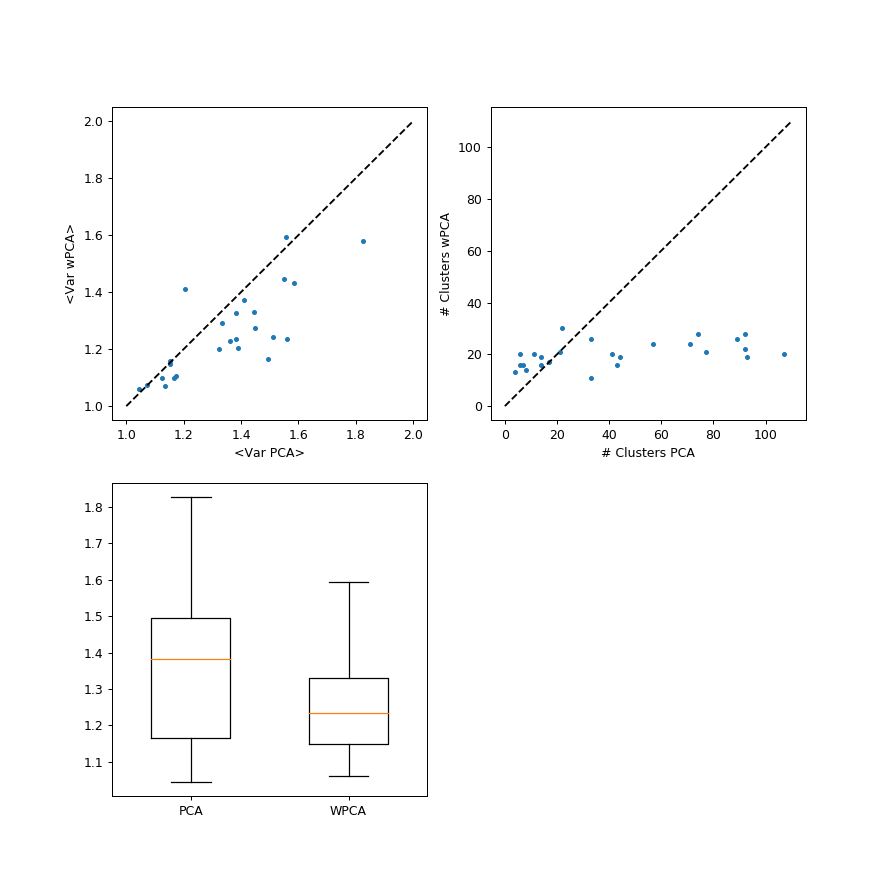

In [92]:
%matplotlib notebook

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(var_pca_all,var_wpca_all,'.')
plt.plot([1, 2],[1, 2],'k--')
plt.xlabel('<Var PCA>')
plt.ylabel('<Var wPCA>')
plt.show()

plt.subplot(2,2,2)
plt.plot(nclass_pca_all,nclass_wpca_all,'.')
plt.plot([0, 110],[0, 110],'k--')
plt.xlabel('# Clusters PCA')
plt.ylabel('# Clusters wPCA')
plt.show()


plt.subplot(2,2,3)
plt.boxplot([var_pca_all,var_wpca_all],widths=.5,labels=['PCA', 'WPCA'])

plt.show()


savefig("Figure_cluster_variability_group_v3.eps",)



<IPython.core.display.Javascript object>


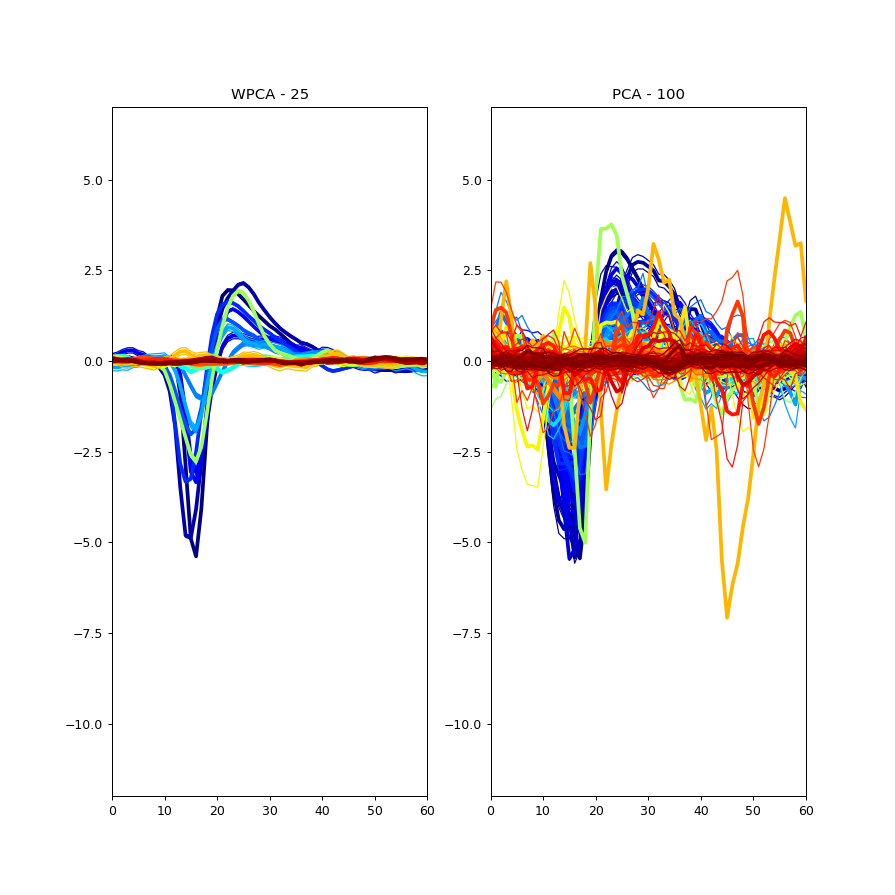

<IPython.core.display.Javascript object>


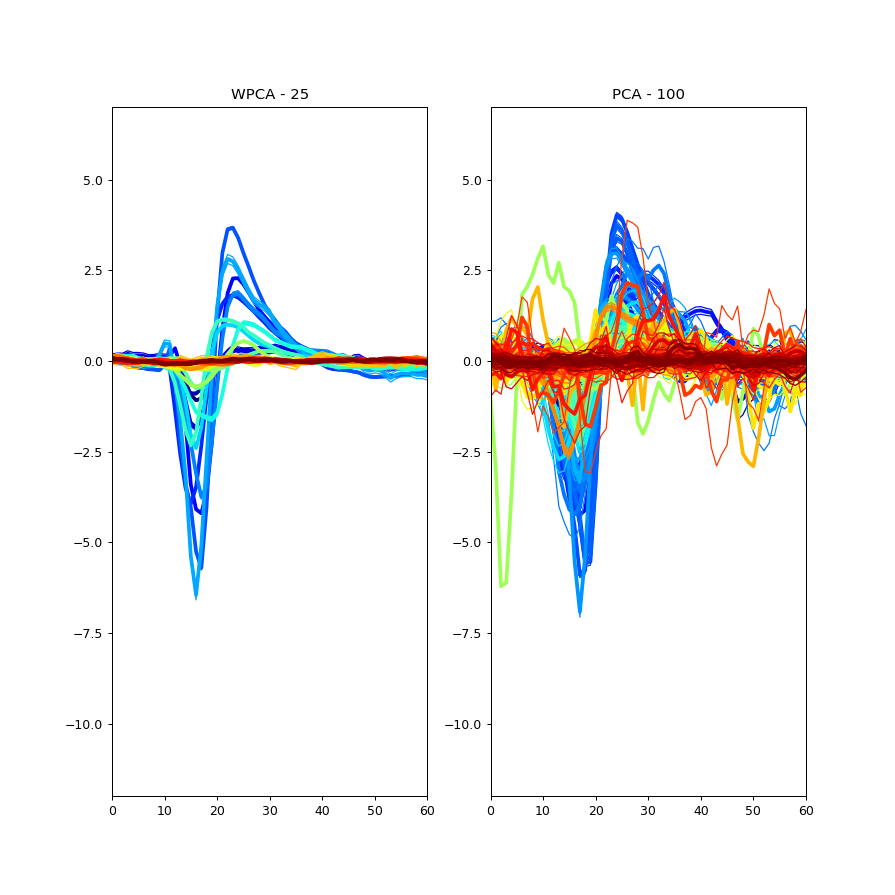

<IPython.core.display.Javascript object>


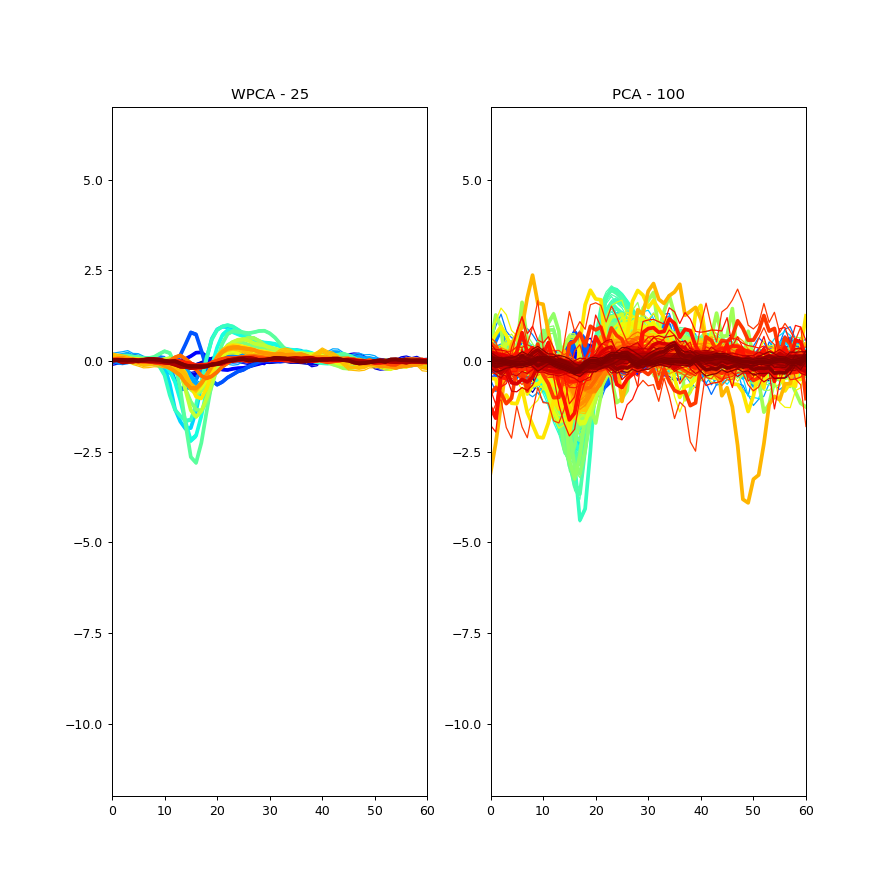

<IPython.core.display.Javascript object>


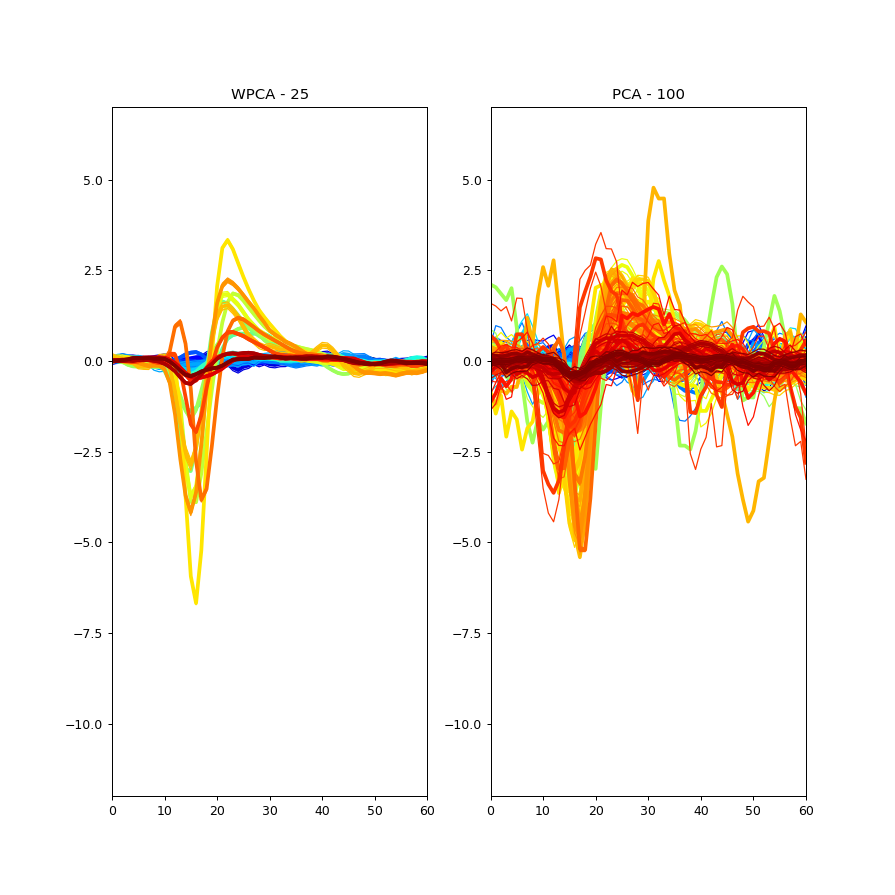

<IPython.core.display.Javascript object>


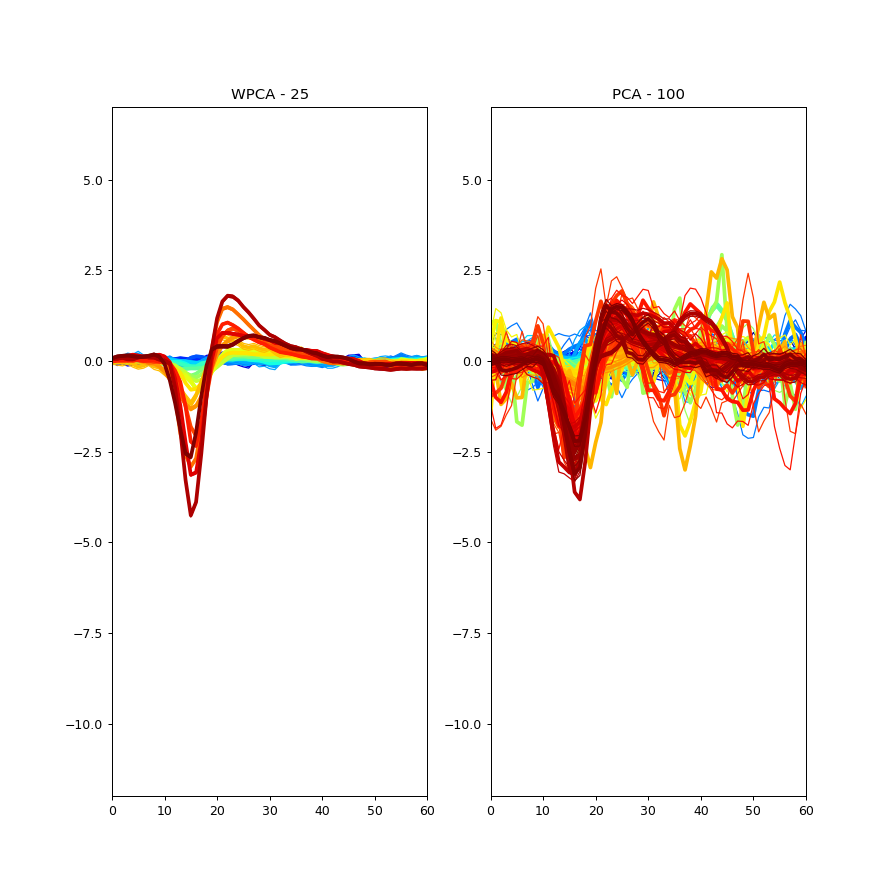

In [69]:
%matplotlib notebook

for ich in [0, 7, 14, 21, 28]:


    nclass = np.max(spike_train_wpca[:,1])+1
    colors = cmap(np.linspace(0, 1, nclass))
    win = np.arange(-30,30+1)
    m_wpca = np.zeros((nclass,len(win)))
    s_wpca = np.zeros((nclass,len(win)))
    for iclus in range(nclass):
        c=0;
        idx = np.where(np.logical_and(np.logical_and(spike_train_wpca[:,0]<(recordings.data.shape[0]-31),spike_train_wpca[:,0]>30),spike_train_wpca[:,1]==iclus))[0]
        for i in win:
            m_wpca[iclus,c] = np.mean(recordings.data[spike_train_wpca[idx,0]+i,ich])
            s_wpca[iclus,c] = np.std(recordings.data[spike_train_wpca[idx,0]+i,ich])/len(idx)**(.5)
            c=c+1



    nclass = np.max(spike_train_pca[:,1])+1
    colors = cmap(np.linspace(0, 1, nclass))
    win = np.arange(-30,30+1)
    m_pca = np.zeros((nclass,len(win)))
    s_pca = np.zeros((nclass,len(win)))
    for iclus in range(nclass):
        c=0;
        idx = np.where(np.logical_and(np.logical_and(spike_train_pca[:,0]<(recordings.data.shape[0]-31),spike_train_pca[:,0]>30),spike_train_pca[:,1]==iclus))[0]

        for i in win:
            m_pca[iclus,c] = np.mean(recordings.data[spike_train_pca[idx,0]+i,ich])
            s_pca[iclus,c] = np.std(recordings.data[spike_train_pca[idx,0]+i,ich])/len(idx)**(.5)
            c=c+1


    plt.figure(figsize=(10,10))
    # plt.figure
    plt.subplot(1,2,1)
    cmap = plt.get_cmap('jet')

    nclass = np.max(spike_train_wpca[:,1])+1
    colors = cmap(np.linspace(0, 1, nclass))
    for iclus in range(nclass):
        plt.plot(m_wpca[iclus,:],c=colors[iclus],linewidth=3)
        plt.plot(m_wpca[iclus,:]+s_wpca[iclus,:],c=colors[iclus],linewidth=1)
        plt.plot(m_wpca[iclus,:]-s_wpca[iclus,:],c=colors[iclus],linewidth=1)

    plt.xlim(0, 60)
    plt.ylim(-12, 7)
    plt.title('WPCA - ' + str(nclass))


    plt.subplot(1,2,2)

    nclass = np.max(spike_train_pca[:,1])+1
    colors = cmap(np.linspace(0, 1, nclass))
    for iclus in range(nclass):
        plt.plot(m_pca[iclus,:],c=colors[iclus],linewidth=3)
        plt.plot(m_pca[iclus,:]+s_pca[iclus,:],c=colors[iclus],linewidth=1)
        plt.plot(m_pca[iclus,:]-s_pca[iclus,:],c=colors[iclus],linewidth=1)

    plt.xlim(0, 60)
    plt.ylim(-12, 7)
    plt.title('PCA - ' + str(nclass))

    plt.show()


    savefig("Figure1_waveforms_example_ch" + str(ich) + "_v3.eps")


In [92]:
aux,idx1,idx2 = np.intersect1d(spike_index_clear_wpca[:,0],spike_index_clear_pca[:,0],return_indices=True)
print(idx1.shape)
print(idx2.shape)
print(spike_index_clear_wpca.shape)
print(spike_index_clear_pca.shape)
spk_wpca = spike_index_clear_wpca[idx1,:]
spk_pca = spike_index_clear_pca[idx2,:]

print(spk_wpca.shape)
print(spk_pca.shape)
print(np.max(spike_index_clear_wpca[:,1]))
print(np.max(spike_index_clear_pca[:,1]))


aux,idx1,idx_ = np.intersect1d(spike_index_clear_wpca[:,0],spike_train_wpca[:,0],return_indices=True)
spk_wpca = spike_index_clear_wpca[idx1,:]
spk_wpca[:,1] = spike_train_wpca[idx_,1]

aux,idx2,idx_ = np.intersect1d(spike_index_clear_pca[:,0],spike_train_pca[:,0],return_indices=True)
spk_pca = spike_index_clear_pca[idx2,:]
spk_pca[:,1] = spike_train_pca[idx_,1]

print(spk_wpca.shape)
print(spk_pca.shape)
print(np.unique(spk_wpca))
print(np.unique(spk_pca))

aux,idx1,idx_ = np.intersect1d(spike_index_clear_wpca[:,0],spike_train_wpca[:,0],return_indices=True)
spk_wpca = spike_index_clear_wpca
spk_wpca[:,1] = -1
spk_wpca[idx1,1] = spike_train_wpca[idx_,1]

aux,idx2,idx_ = np.intersect1d(spike_index_clear_pca[:,0],spike_train_pca[:,0],return_indices=True)
spk_pca = spike_index_clear_pca
spk_pca[:,1] = -1
spk_pca[idx2,1] = spike_train_pca[idx_,1]

print(spk_wpca.shape)
print(spk_pca.shape)
print(np.unique(spk_wpca))
print(np.unique(spk_pca))

(28346,)
(28346,)
(28426, 2)
(28426, 2)
(28346, 2)
(28346, 2)
99
29
(11994, 2)
(2654, 2)
[      0       1       2 ... 1799631 1799662 1799835]
[      0       1       2 ... 1798222 1798824 1799804]
(28426, 2)
(28426, 2)
[     -1       0       1 ... 1799886 1799894 1799975]
[     -1       0       1 ... 1799886 1799894 1799975]


<IPython.core.display.Javascript object>


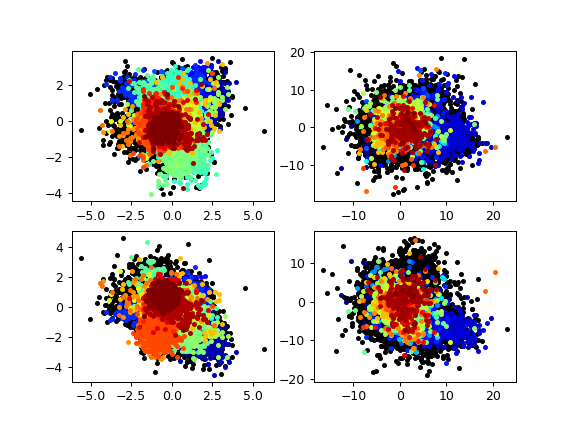

In [93]:

# all spikes but with the final classification..

plt.figure()



cmap = plt.get_cmap('jet')
nclass = np.max(spk_wpca[:,1])+1
colors = cmap(np.linspace(0, 1, nclass))

wpc1=0;
wpc2=1;

plt.subplot(2,2,1)
idx = np.where(spk_wpca[:,1] == -1)
plt.plot(np.squeeze(score_wpca[idx,wpc1,0]),np.squeeze(score_wpca[idx,wpc2,0]),'.k')
for i in range(nclass):
    idx = np.where(spk_wpca[:,1] == i)
    plt.plot(np.squeeze(score_wpca[idx,wpc1,0]),np.squeeze(score_wpca[idx,wpc2,0]),'.',c=colors[i])

wpc1=0;
wpc2=2;

plt.subplot(2,2,3)
idx = np.where(spk_wpca[:,1] == -1)
plt.plot(np.squeeze(score_wpca[idx,wpc1,0]),np.squeeze(score_wpca[idx,wpc2,0]),'.k')
for i in range(nclass):
    idx = np.where(spk_wpca[:,1] == i)
    plt.plot(np.squeeze(score_wpca[idx,wpc1,0]),np.squeeze(score_wpca[idx,wpc2,0]),'.',c=colors[i])

    
wpc1=0;
wpc2=1;
    
nclass = np.max(spk_pca[:,1])+1

colors = cmap(np.linspace(0, 1, nclass))
plt.subplot(2,2,2)

idx = np.where(spk_pca[:,1] == -1)
plt.plot(np.squeeze(score_pca[idx,wpc1,0]),np.squeeze(score_pca[idx,wpc2,0]),'.k')

for i in range(nclass):
    idx = np.where(spk_pca[:,1] == i)
    plt.plot(np.squeeze(score_pca[idx,wpc1,0]),np.squeeze(score_pca[idx,wpc2,0]),'.',c=colors[i])

wpc1=0;
wpc2=2;

plt.subplot(2,2,4)

idx = np.where(spk_pca[:,1] == -1)
plt.plot(np.squeeze(score_pca[idx,wpc1,0]),np.squeeze(score_pca[idx,wpc2,0]),'.k')
for i in range(nclass):
    idx = np.where(spk_pca[:,1] == i)
    plt.plot(np.squeeze(score_pca[idx,wpc1,0]),np.squeeze(score_pca[idx,wpc2,0]),'.',c=colors[i])

    
savefig("PCscores_ch0_all_spikes_from_spike_train_v3.eps")
# savefig("PCscores_ch0_same_spikes_v3.eps")

# savefig("teste.eps")
# plt.xlim(-2, 2)
# plt.ylim(-.2, .2)




<IPython.core.display.Javascript object>


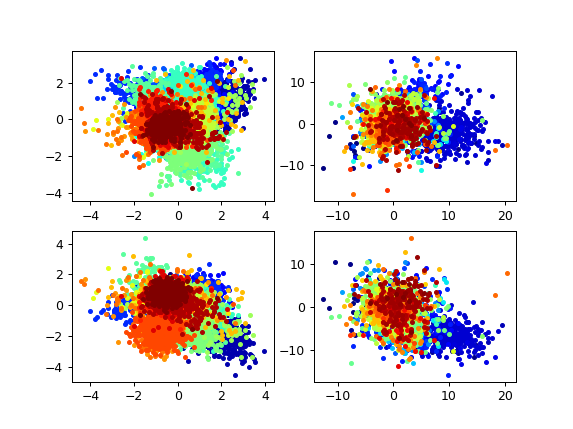

In [79]:
# only with the same detected spikes...

plt.figure()



cmap = plt.get_cmap('jet')
nclass = np.max(spk_wpca[:,1])+1
colors = cmap(np.linspace(0, 1, nclass))

wpc1=0;
wpc2=1;

plt.subplot(2,2,1)
for i in range(nclass):
    idx = np.where(spk_wpca[:,1] == i)
    plt.plot(np.squeeze(score_wpca[idx1[idx],wpc1,0]),np.squeeze(score_wpca[idx1[idx],wpc2,0]),'.',c=colors[i])

wpc1=0;
wpc2=2;

plt.subplot(2,2,3)
for i in range(nclass):
    idx = np.where(spk_wpca[:,1] == i)
    plt.plot(np.squeeze(score_wpca[idx1[idx],wpc1,0]),np.squeeze(score_wpca[idx1[idx],wpc2,0]),'.',c=colors[i])

    
wpc1=0;
wpc2=1;
    
nclass = np.max(spk_pca[:,1])+1

colors = cmap(np.linspace(0, 1, nclass))
plt.subplot(2,2,2)
for i in range(nclass):
    idx = np.where(spk_pca[:,1] == i)
    plt.plot(np.squeeze(score_pca[idx2[idx],wpc1,0]),np.squeeze(score_pca[idx2[idx],wpc2,0]),'.',c=colors[i])

wpc1=0;
wpc2=2;

plt.subplot(2,2,4)
for i in range(nclass):
    idx = np.where(spk_pca[:,1] == i)
    plt.plot(np.squeeze(score_pca[idx2[idx],wpc1,0]),np.squeeze(score_pca[idx2[idx],wpc2,0]),'.',c=colors[i])

    
savefig("PCscores_ch0_same_spikes_from_spike_train_v3.eps")
# savefig("PCscores_ch0_same_spikes_v3.eps")

# savefig("teste.eps")
# plt.xlim(-2, 2)
# plt.ylim(-.2, .2)





<IPython.core.display.Javascript object>


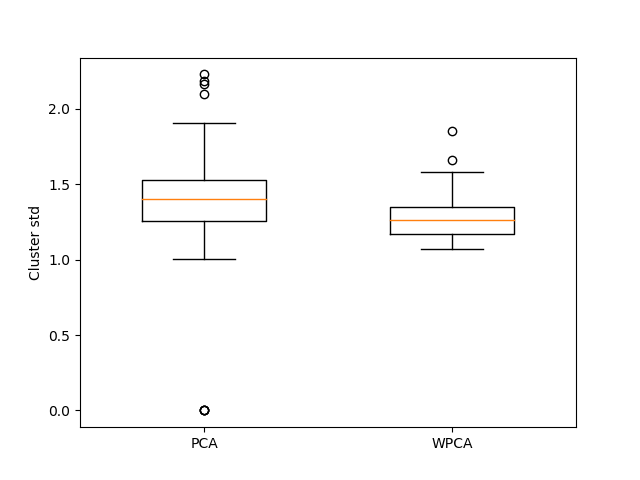

In [38]:
plt.figure()
plt.boxplot([var_pca,var_wpca],widths=.5,labels=['PCA', 'WPCA'])

plt.ylabel('Cluster std')

savefig("Figure4_cluster_variance_v3.eps")